# Binary Classifier on Single records

### Most basic example.
This notebook will show how to set-up learning features (i.e. fields we want to use for modeling) and read them from a CSV file. Then create a very simple feed-forward Neural Net to classify fraud vs. non-fraud, train the model and test it.

Throughout these notebooks we will not explain how Neural Nets work, which loss functions exists, how NN's are optimized, what stochastic gradient decent is etc... There are some excellent resources online which do this in great detail.

#### The math
One thing we will quickly do is recap what a FeedForward (aka Linear Layer) is, just to build some intuition and to contrast this with other layers which will be explained later.

Linear Layers are often presented as shown below on the left, basically as weights that connect one layer to the next. Each node in the second layer is a weighted sum of the input values to which a bias term is added. So for nodes $h_j$ for h=1->3; $h_j= (\sum_{i=1}^4 x_i*w_{ij})+\beta_{j}$. 

If we look more in detail what happens on the right hand size we see that for a single node we effectively take the weighted sum, add a bias and then perform an activation function. The activation is needed so the model can learn non-linearity. If all NN's did was stacking linear operations, the end-result would be a linear combination of the input, ideally we would want models to learn more complex relations, non-linear activations enable that. In most DeepLearning cases the `ReLU` function is used for activation. 

Taking the weighted sum on a large scale for multiple nodes in one go, is nothing more or less than taking matrix dot-product. Same for adding the bias, that is just a matrix element wise addition. Another way of looking at this is considering the input __I__ to be a vector of size (1,4) and the hidden layer __H__ a vector of size (1,3), if we set-up a weight matrix __W__ of size (4,3), and a bias vector __$\beta$__ of size (1,3) then $H = act(I \odot W + \beta)$. The dot product of the input array with the weight matrix plus a bias vector which is then 'activated'

The hidden layer would typically be connected to a next layer, and a next and a next... until we get to an output layer. The formula for the output $O$ would thus be something like; $O = act(act(act(I \odot W_1 + \beta_1) \odot W_2 + \beta_2) \odot W_3 + \beta_3)$ if we had 3 hidden layers.

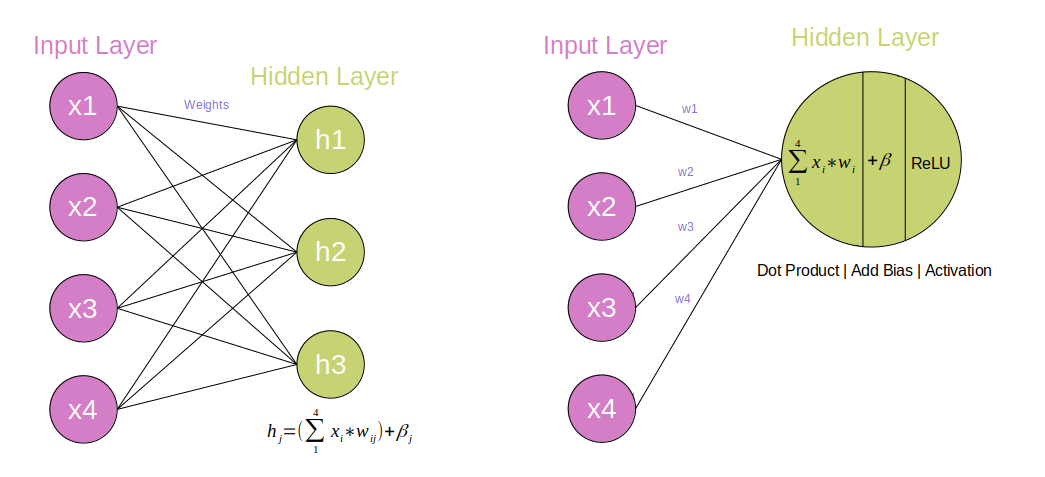

#### The Intuition
We can think of the __dot products and weights__ as taking bit of each input and combining that into a __hidden__ 'feature'. For instance if $X_1$ indicates 'age' category *elder* and $X_4$ indicates 'gender' *male*. If the inputs are 0 and 1 for yes/no, then using a positive weight $w_1$ and $w_4$ and 0 for the other weights, then we'd have a feature which 'activates' for an elder male customer.

We can think of the __bias__ as setting a minimal barrier or a reinforcement of the feature. For instance in above feature if we wanted our *elder male* hidden feature to only activate as it reaches .7 we could add a -.7 bias. If we wanted the feature to activate easier, we could add a positive bias.

Our Neural Nets will learn which weights and biases work best in order to solve a specific task. In Feedforward NN's they are the *'learnable'* parameters

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. 

Below code snipped follows a structure we'll see a lot.
- First we define features, these are fields we'll want to use. In this case we're defining 'Source' features, features that are in the data source, here the file. As parameters we provide the name as found in the first row of the file and a type.
- Then we bundle them in a `TensorDefinition`, this is essentially a group of features. We give it a name and list of features as input.
- Lastly we set up and engine of type `EnginePandasNumpy` and call the `from_csv` method with the TensorDefinition and the `file` name. This `from_csv` method will read the file and return a Pandas DataFrame object. The `inference` parameter specifies that we are in training mode, so any stats the feature needs to use will be gathered.

All this will return a Pandas DataFrame with __594643 rows__ (the number of transactions) and __6 columns__ (the number of features we defined), it can be use to perform basic data analysis.


In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    
df

2021-09-15 15:11:54.144 d373c7.engines.common          INFO     Start Engine...
2021-09-15 15:11:54.145 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-15 15:11:54.145 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-15 15:11:54.145 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2021-09-15 15:11:54.351 d373c7.engines.panda_numpy     INFO     Building Panda for : <Source_Derive_Source> from DataFrame. Inference mode <False>
2021-09-15 15:11:54.352 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Source_Derive_Source
2021-09-15 15:11:54.354 d373c7.engines.panda_numpy     INFO     Done creating Source_Derive_Source. Shape=(594643, 6)
2021-09-15 15:11:54.355 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: base


,age,gender,merchant,category,amount,fraud
0,4,M,M348934600,es_transportation,4.55,0
1,2,M,M348934600,es_transportation,39.68,0
2,4,F,M1823072687,es_transportation,26.89,0
3,3,M,M348934600,es_transportation,17.25,0
4,5,M,M348934600,es_transportation,35.72,0
...,...,...,...,...,...,...
594638,3,F,M1823072687,es_transportation,20.53,0
594639,4,F,M1823072687,es_transportation,50.73,0
594640,2,F,M349281107,es_fashion,22.44,0
594641,5,M,M1823072687,es_transportation,14.46,0


## Define some derived features
After we've defined and read the source features, we can define some __derived__ features. Derived features apply a form of transformation to the source features, depending on the type of feature.

In this example 3 transformations are used;
- `FeatureNormalizeScale` The amount is scaled between 0 and 1.
- `FeatureOneHot` The categorical features are turned into one-hot encoded fields. 
- `FeatureLabelBinary` The Fraud field is marked as Label. This is not really a transformation, it's just so the model knows which label to use.

We apply above transformations because Neural Nets prefer data that is in Binary ranges 0->1 or normally distributed

This will create a total of 78 features we can use in the model.  We create a second list with the label.

In [5]:
amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
age_oh = ft.FeatureOneHot('age_one_hot', ft.FEATURE_TYPE_INT_8, age)
gender_oh = ft.FeatureOneHot('gender_one_hot', ft.FEATURE_TYPE_INT_8, gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', ft.FEATURE_TYPE_INT_8, merchant)
category_oh = ft.FeatureOneHot('category_one_hot', ft.FEATURE_TYPE_INT_8, category)
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

features = ft.TensorDefinition(
    'features', 
    [
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_scale,
    ])

label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([features, label])

with en.EnginePandasNumpy() as e:
    ft = e.from_csv(features, file, inference=False)
    lb = e.from_csv(label, file, inference=False)

2021-09-15 15:11:57.210 d373c7.engines.common          INFO     Start Engine...
2021-09-15 15:11:57.210 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-15 15:11:57.211 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-15 15:11:57.211 d373c7.engines.panda_numpy     INFO     Building Panda for : features from file ../../../../data/bs140513_032310.csv
2021-09-15 15:11:57.397 d373c7.engines.panda_numpy     INFO     Building Panda for : <Source_Derive_Source> from DataFrame. Inference mode <False>
2021-09-15 15:11:57.397 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Source_Derive_Source
2021-09-15 15:11:57.398 d373c7.engines.panda_numpy     INFO     Done creating Source_Derive_Source. Shape=(594643, 5)
2021-09-15 15:11:57.400 d373c7.engines.panda_numpy     INFO     Create amount_scale Normalize/Scale amount. Min. 0.00 Max. 8329.96
2021-09-15 15:11:57.462 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: features
202

In [6]:
ft

,age__0,age__1,age__2,age__3,age__4,age__5,age__6,age__U,gender__E,gender__F,...,category__es_hotelservices,category__es_hyper,category__es_leisure,category__es_otherservices,category__es_sportsandtoys,category__es_tech,category__es_transportation,category__es_travel,category__es_wellnessandbeauty,amount_scale
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.000546
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.004764
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0.003228
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.002071
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.004288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594638,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0.002465
594639,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0.006090
594640,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.002694
594641,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.001736


In [7]:
lb

,fraud_label
0,0
1,0
2,0
3,0
4,0
...,...
594638,0
594639,0
594640,0
594641,0


## Convert to Numpy

Now we convert the panda DataFrame to a list of Numpy arrays (which can be used for training). The `NumpyList` will have an entry for each of the Learning types. It will split out the *Binary*, *Continuous*, *Categorical* and *Label* Learning type __features__. Each Learning type will have a list entry in the `NumpyList` object

This step is needed so the models understand how to use the various features in the learning and testing processes. 

In this case we have a first list with 77 binary (one-hot-endoded) features, the second is a list with 1 continuous feature (the amount) and the last list is the label (Fraud or Non-Fraud).

In [8]:
with en.EnginePandasNumpy() as e:
    ft_np = e.to_numpy_list(features, ft)
    lb_np = e.to_numpy_list(label, lb)

data_list = en.NumpyList(ft_np.lists + lb_np.lists)
    
print(data_list.shapes)
print(data_list.dtype_names)

2021-09-15 15:12:07.269 d373c7.engines.common          INFO     Start Engine...
2021-09-15 15:12:07.269 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-15 15:12:07.270 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-15 15:12:07.270 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2021-09-15 15:12:07.271 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Binary
2021-09-15 15:12:07.289 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: float32
2021-09-15 15:12:07.289 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Continuous
2021-09-15 15:12:07.291 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2021-09-15 15:12:07.291 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Label


[(594643, 77), (594643,), (594643,)]
['int8', 'float32', 'int8']


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

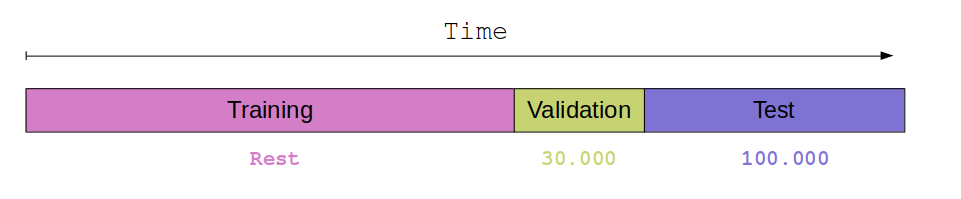

In [9]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del ft, lb
del ft_np, lb_np
del data_list

gc.collect()
print('Done')

Training Data shapes [(464643, 77), (464643,), (464643,)]
Validation Data shapes [(30000, 77), (30000,), (30000,)]
Test Data shapes [(100000, 77), (100000,), (100000,)]
Done


## Set-up devices

In [10]:
device, cpu = pt.init_devices()

2021-09-15 15:12:12.072 d373c7.pytorch.common          INFO     Torch Version : 1.9.0+cu111
2021-09-15 15:12:12.144 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-09-15 15:12:12.144 d373c7.pytorch.common          INFO     Cuda Version  : 11.1


# Define Model


The training data set has to be balanced for Neural Nets. A balanced data set has a more or less equal amount of each class of the label. In our case fraud vs. non-fraud classes. Failing to balance the data can have dramatic results, Neural Nets are lazy, in extreme cases they might just plain always predict the majority class.

Fraud data-sets always have more non-fraud than fraud records. In this example the fraud class will be aggressively upsampled in the training phase by a custom `ClassSampler`. It oversamples the minority label until it matches the majority label in quantity. This may not be a good idea for a really large data sets.

> 1. First set-up a NumpyListDataSet for both the training data-set and validation data-set. A NumpyListDataSet is a specialized `Pytorch Dataset` which keeps the data as numpy arrays in memory and converts on the fly to `Pytorch Tensors`
> 2. Set-up a sampler for the training set only. The sampler will over-sample the '1'/fraud class. Note that this means the training and validation sets are balanced *differently*. This is important when interpreting the plots.
> 3. Wrap the dataset in a Pytorch Dataloader. `Dataloaders` allow the training loop to iterate over `Datasets`
> 4. Create a model. Here the most basic __GeneratedClassifier__ is used. __The GeneratedClassifier__ will create a model using the information it has about the features. *We are defining it to have 1 hidden layer of size 16*. 

In [11]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)
train_sampler = pt.ClassSamplerMulti(model_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.GeneratedClassifier(model_features, linear_layers=[16])
print(m)

GeneratedClassifier(
  Number of parameters : 1313. Loss : SingleLabelBCELoss,  mean
  (streams): ModuleList(
    (0): TensorDefinitionHead(lcs=['Binary', 'Continuous'])
  )
  (tail): TailBinary(
    (layers): Sequential(
      (tail_lin_01): Linear(in_features=78, out_features=16, bias=True)
      (tail_act_01): ReLU()
      (tail_dropout_01): Dropout(p=0.1, inplace=False)
      (tail_batch_norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (tail_binary): Linear(in_features=16, out_features=1, bias=True)
      (tail_bin_act): Sigmoid()
    )
  )
)


The generated model consists of one stream -as there is one TensorDefinition containing modeling features-. That stream has a later of type __TensorDefinitionHead__ which will in this case just concatenate our *Binary* (77 one hot) and our Continuous (amount) features into a 78 shape tensor.

Which is consequently processed through the __Tail__. As we have a binary label, the tail is binary, it will process using the requested 16 size hidden layer and then output a final output layer of size 1. The output will be a score, ranging from 0 to 1 (because of the sigmoid), indicating the likelyhood of Fraud. The higher, the more certain the model is it bad.

Grapically this network looks like below (Some of the layers have been omitted for simplicity)

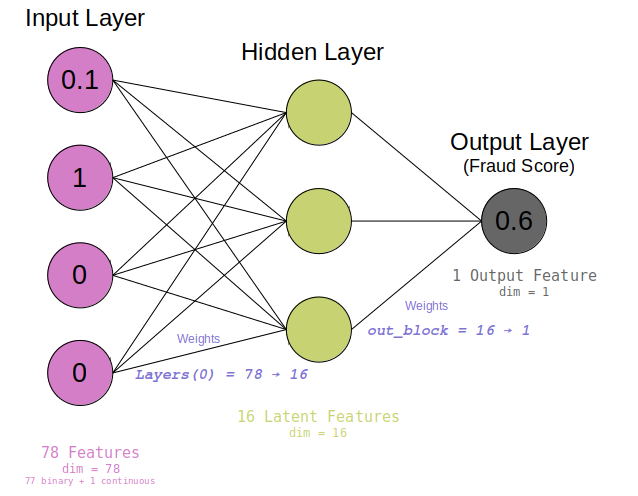

# Start Training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This function iterates over the batches, gradually increasing the learning rate from a minimum to a maximum learning rate. It tends to show where we can find a good learning rate. In this case at around __3e-3__ we start a very steep decent. The model does not learn at lower than __1e-3__ learning rates. Beyond __1e-2__ it flattens out, stops learning at around __2e-2__ and explodes later. This exloding can be validate by running with a higher number of iteration and higher upper bound. A good learning rate is a location where the curve has a steep descent, but not too far down the curve. In this case around __5e-3__

2021-09-15 15:12:16.750 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 488.25it/s]
2021-09-15 15:12:19.506 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


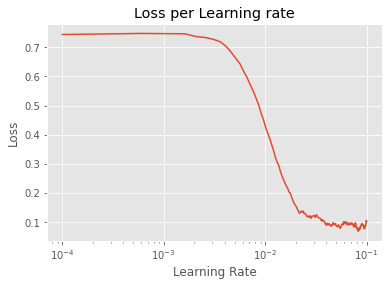

In [12]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
In our examples we will use a one_cycle logic. This is a training logic which starts at a learning rate lower than the specified learning rate, over the course of training works its way up to the specified learning rate and decreases again towards the end of the learning cycle. Proposed by [Leslie N. Smith, A DISCIPLINED APPROACH TO NEURAL NETWORK HYPER-PARAMETERS](https://arxiv.org/pdf/1803.09820.pdf)

> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.
> The result graph plots the accuracy and loss evolution at each Epoch for both the training and the validation set. We see the model behaves fairly well during training. The loss goes up slightly in the middle of the training. This is the one_cycle logic which is reaching the max learning rate. 

Epoch 010/010: 100%|██████████| 3866/3866 [00:04<00:00, 792.10it/s, train_loss=0.0553, train_acc=0.978, val_loss=0.0359, val_acc=0.983]


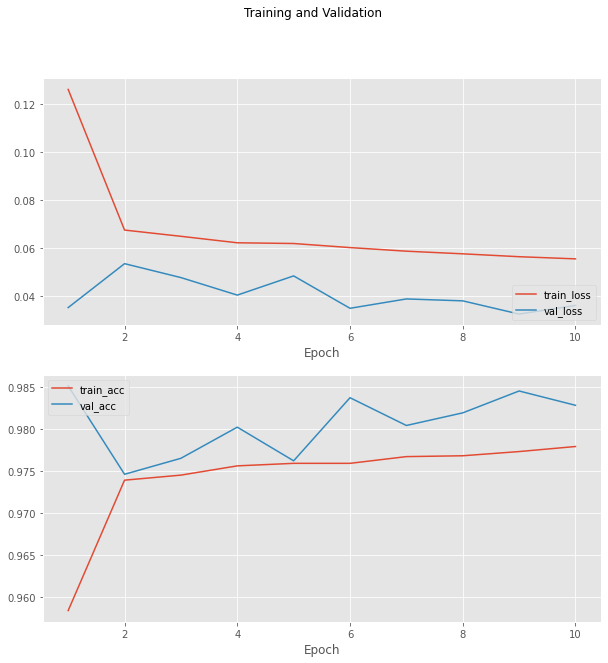

In [13]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data
> Test the model on the test set, it is data that was not seen during training and allows us to validate model results. This model behaves fairly OK. It is really good at catching the fraud. It has a fairly low False Negative rate. (Lower left corner of the Confusion Matrix). But it also has a fairly large False Positive rate (Upper right corner of the Confusion Matrix).
Some research would be needed but this is likely at least partially due to the oversampling. The model saw much more fraud during the training, so it might not be surprising it gets relatively good at predicting it.

Testing in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 1046.42it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     98926
         1.0       0.42      0.98      0.59      1074

    accuracy                           0.99    100000
   macro avg       0.71      0.98      0.79    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9988
ap score  : 0.9290
-----------------------------------------------------


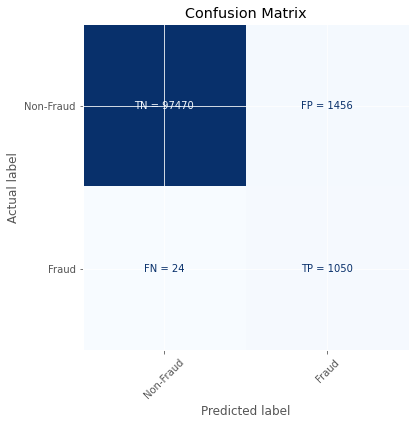

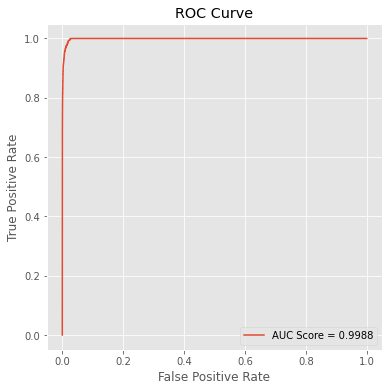

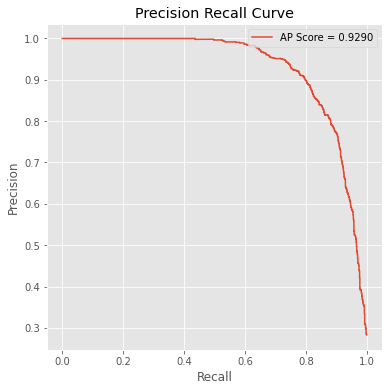

In [14]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

# Conslusion
This is a first example that showed how we can read a file, set-up some features (fields), test and train a really simple Feed-Forward Neural Net model.